# Main module for DM-21cm paper (LC, PS, plots)

ArXiv 2312.17499

In [1]:
import py21cmfast as p21c
import platform, time, os, h5py, shutil, matplotlib
import cosmo_tools as cosmo
import PyLab as PL
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams.update({
    'text.usetex': True,
    'font.family':'Times',
    'text.latex.preamble': r'\usepackage{newtxtext,newtxmath}'})
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib widget

/Users/cangtao/FileVault/GitHub/21cmFAST/src/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
[cangtaodeMacBook-Pro.local:05541] shmem: mmap: an error occurred while determining whether or not /var/folders/4l/x26d55ys0r77d01llftzzrfh0000gn/T//ompi.cangtaodeMacBook-Pro.501/jf.0/811335680/sm_segment.cangtaodeMacBook-Pro.501.305c0000.0 could be created.


# LightCone Plot

density range: [-0.60, 1.93]
DensityLocation: 0.28
Plot saved to: /Users/cangtao/Desktop/SlicePlot.pdf


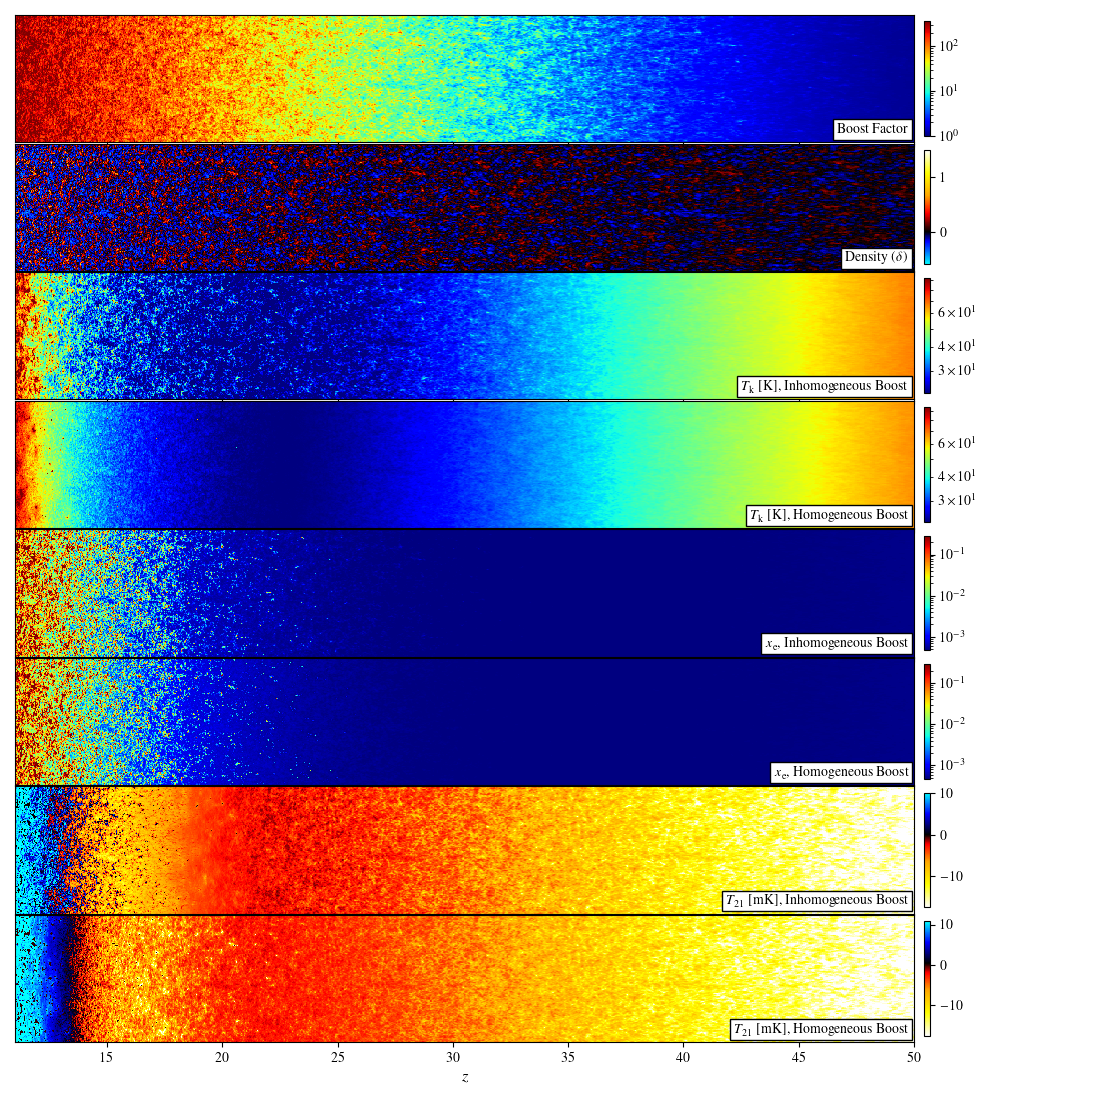

In [2]:
def Plot_LC():
    FontSize = 12
    zmax = 50
    f0 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/IHM.h5'
    f1 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/HMG.h5'
    
    PlotFile = '/Users/cangtao/Desktop/SlicePlot.pdf'

    lc = p21c.LightCone.read(f0)
    z = lc.lightcone_redshifts
    boost  = lc.Boost_box[1,:,:]
    boost_global = lc.global_Boost
    density = lc.density[1,:,:]
    
    # Set color bar range with global signal range
    # tb_ = lc.global_brightness_temp
    mask_glb = lc.node_redshifts <= zmax
    TbMin = lc.global_brightness_temp[mask_glb].min()
    TbMax = lc.global_brightness_temp[mask_glb].max()
    BlackLocation = -TbMin/(TbMax - TbMin)
    
    EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',\
             [(0, 'white'),(0.2, 'yellow'),(0.4, 'orange'),(0.55, 'red'),\
              (BlackLocation, 'black'),((BlackLocation + 1)/2, 'blue'),(1, 'cyan')])
    
    # Design densiti field color, previouly using 'nipy_spectral'
    print("density range: [{:.2f}, {:.2f}]".format(np.min(density), np.max(density)))
    density_filter = 1.5
    if np.max(density) < density_filter: density_filter = np.max(density)
    density[density > density_filter] = density_filter
    DensityLocation = 1/(density_filter +1)
    DensityLocation = -np.min(density)/(density_filter - np.min(density))
    
    print("DensityLocation: {:.2f}".format(DensityLocation))
    
    Density_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',\
             [(0, 'white'),(0.08, 'yellow'),(0.16, 'orange'),(0.2, 'red'),\
              (DensityLocation, 'black'),((DensityLocation + 1)/2, 'blue'),(1, 'cyan')])
    Density_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',\
             [
                (0, 'cyan'),
                (0.2, 'blue'),
                (DensityLocation, 'black'),
                (0.45, 'red'),
                (0.6, 'orange'),
                (0.8, 'yellow'),
                (1, 'white')])
    Density_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',\
             [
                (0, 'cyan'),
                (0.2, 'blue'),
                (DensityLocation, 'black'),
                (0.45, 'red'),
                (0.6, 'orange'),
                (0.8, 'yellow'),
                (1, 'white')])
    
    BOX_LEN = lc.user_params.BOX_LEN
    HII_DIM = lc.user_params.HII_DIM
    x = np.linspace(0, BOX_LEN, HII_DIM)

    # now get other stats
    lc0 = p21c.LightCone.read(f0)
    lc1 = p21c.LightCone.read(f1)

    tb = lc0.brightness_temp[1,:,:]
    gtb = lc0.global_brightness_temp[mask_glb]
    tb1 = lc1.brightness_temp[1,:,:]
    gtb1 = lc1.global_brightness_temp[mask_glb]
    tk = lc0.Tk_box[1,:,:]
    gtk = lc0.global_Tk[mask_glb]
    tk1 = lc1.Tk_box[1,:,:]
    gtk1 = lc1.global_Tk[mask_glb]

    xe = 1 - lc0.xH_box[1,:,:]
    gxe = 1 - lc0.global_xH[mask_glb]
    xe1 = 1 - lc1.xH_box[1,:,:]
    gxe1 = 1 - lc1.global_xH[mask_glb]

    z, x = np.meshgrid(z, x)

    plt.rcParams.update({'font.family':'Times'})
    plt.rcParams['text.usetex'] = True

    fig, axs = plt.subplots(8, 1, sharex = True, sharey = True)
    fig.set_size_inches(11, 11)
    
    c0 = axs[0].pcolor(z, x, boost, cmap='jet', norm = LogNorm(vmin = boost_global.min(), vmax = boost_global.max()), rasterized=True)
    axs[0].set_yticks([])
    cbar = fig.colorbar(c0, ax=axs[0], shrink = 0.9, pad = 0.01)
    axs[0].text(0.993, 0.05, "Boost Factor", rotation=0, verticalalignment='bottom', transform=axs[0].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    
    c1 = axs[1].pcolor(z, x, density, cmap=Density_colour, vmin = np.min(density), vmax = density_filter, rasterized=True)
    plot_zmax = zmax if zmax < np.max(lc.lightcone_redshifts) else np.max(lc.lightcone_redshifts)
    axs[0].set_xlim(np.min(lc.lightcone_redshifts), plot_zmax)
    
    axs[1].set_yticks([])
    cbar = fig.colorbar(c1, ax=axs[1], shrink = 0.9, pad = 0.01)
    axs[1].text(0.993, 0.05, "Density ($\delta$)", rotation=0, verticalalignment='bottom', transform=axs[1].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    
    c2 = axs[2].pcolor(z, x, tk, cmap='jet', norm = LogNorm(vmin = gtk.min(), vmax = gtk.max()), rasterized=True)
    axs[2].set_yticks([])
    cbar = fig.colorbar(c2, ax=axs[2], shrink = 0.9, pad = 0.01)
    # cbar.ax.set_title('$z$')
    axs[2].text(0.993, 0.05, "$T_{\mathrm{k}}$ [K], Inhomogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[2].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    c3 = axs[3].pcolor(z, x, tk1, cmap='jet', norm = LogNorm(vmin = gtk1.min(), vmax = gtk1.max()), rasterized=True)
    axs[3].set_yticks([])
    cbar = fig.colorbar(c3, ax=axs[3], shrink = 0.9, pad = 0.01)
    axs[3].text(0.993, 0.05, "$T_{\mathrm{k}}$ [K], Homogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[3].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    c4 = axs[4].pcolor(z, x, xe, cmap='jet', norm = LogNorm(vmin = gxe.min(), vmax = gxe.max()), rasterized=True)
    axs[4].set_yticks([])
    cbar = fig.colorbar(c4, ax=axs[4], shrink = 0.9, pad = 0.01)
    axs[4].text(0.993, 0.05, "$x_{\mathrm{e}}$, Inhomogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[4].transAxes,
        color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    
    c5 = axs[5].pcolor(z, x, xe1, cmap='jet', norm = LogNorm(vmin = gxe1.min(), vmax = gxe1.max()), rasterized=True)
    axs[5].set_yticks([])
    cbar = fig.colorbar(c5, ax=axs[5], shrink = 0.9, pad = 0.01)
    axs[5].text(0.993, 0.05, "$x_{\mathrm{e}}$, Homogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[5].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    
    c6 = axs[6].pcolor(z, x, tb, cmap = EoR_colour, vmin = gtb.min(), vmax = gtb.max(), rasterized=True)
    axs[6].set_yticks([])
    cbar = fig.colorbar(c6, ax=axs[6], shrink = 0.9, pad = 0.01)
    axs[6].text(0.993, 0.05, "$T_{\mathrm{21}}$ [mK], Inhomogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[6].transAxes,
        color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')
    
    c7 = axs[7].pcolor(z, x, tb1, cmap = EoR_colour, vmin = gtb1.min(), vmax = gtb1.max(), rasterized=True)
    axs[7].set_yticks([])
    cbar = fig.colorbar(c7, ax=axs[7], shrink = 0.9, pad = 0.01)
    axs[7].text(0.993, 0.05, "$T_{\mathrm{21}}$ [mK], Homogeneous Boost", rotation=0, verticalalignment='bottom', transform=axs[7].transAxes,
            color = 'k', fontsize = 10, bbox={'facecolor': 'white', 'edgecolor': 'k', 'boxstyle': 'square'}, horizontalalignment='right')

    axs[7].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')

    plt.tight_layout()
    
    fig.subplots_adjust(hspace = 0.01)
    plt.savefig(PlotFile)
    print('Plot saved to:', PlotFile)

Plot_LC()


# Boost factor and density

/Users/cangtao/Desktop/PS_Boost.pdf
Collapse fraction at redshift 11: 0.27
Boost factor at redshift 11: 362.28


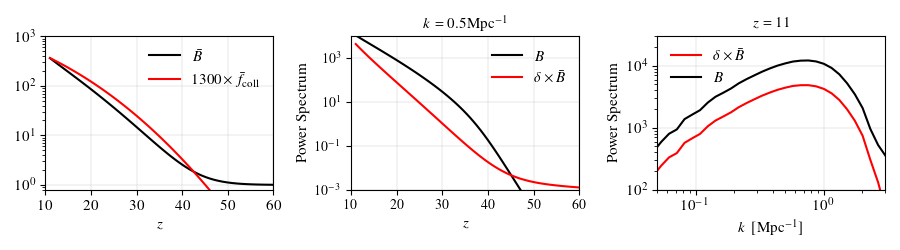

In [3]:
def Plot_Boost_Density():
    
    LineWidth = 1.5
    FontSize = 11

    H5File = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/IHM.h5'
    PlotFile = '/Users/cangtao/Desktop/PS_Boost.pdf'

    PS_dataset = h5py.File('data/PowerSpectrums.h5', 'r')
    PSB = PS_dataset['IHM/Boost/ps'][:]
    PSD = PS_dataset['IHM/density/ps'][:]
    PSB[PSB < 1E-200] = 1E-200
    PSD[PSD < 1E-200] = 1E-200
    z_ax = PS_dataset['IHM/Boost/z'][:]
    k_ax = PS_dataset['IHM/Boost/k'][:]
    z_tmp = PS_dataset['IHM/density/z'][:]
    k_tmp = PS_dataset['IHM/density/k'][:]
    if np.sum(np.abs(z_ax-z_tmp)) > 1E-3 or np.sum(np.abs(k_ax-k_tmp)) > 1E-3:
        raise Exception('Boost and density have different z and k axis')
    PS_dataset.close()

    def Read_PS(fix_z, z, k, dataset):
        if fix_z:
            id1 = PL.Find_Index(x=z, x_axis=z_ax)
            id2 = id1+1
            z1 = z_ax[id1]
            z2 = z_ax[id2]
            f1 = dataset[id1, :]
            f2 = dataset[id2, :]
            f1, f2 = np.log10(f1), np.log10(f2)
            r = (f2 - f1)*(z-z1)/(z2 - z1) + f1
        else:
            id1 = PL.Find_Index(x=k, x_axis=k_ax)
            id2 = id1+1
            x = np.log10(k)
            x1 = np.log10(k_ax[id1])
            x2 = np.log10(k_ax[id2])
            f1 = dataset[:, id1]
            f2 = dataset[:, id2]
            f1, f2 = np.log10(f1), np.log10(f2)
            r = (f2 - f1)*(x-x1)/(x2 - x1) + f1
        r = 10**r
        return r

    # Global Boost
    lc = p21c.LightCone.read(H5File)
    z_boost = lc.node_redshifts
    Boost = lc.global_Boost

    # Fcoll
    d = np.loadtxt('data/Fcoll_tmp.txt')
    z_fcoll = d[:,0]
    fcoll = d[:,1]

    # Get Ps(z)
    PSB_Z = Read_PS(fix_z=0, z=None, k = 0.5, dataset=PSB)
    PSD_Z = Read_PS(fix_z=0, z=None, k = 0.5, dataset=PSD)

    # Get Ps(k)
    PSB_k = Read_PS(fix_z=1, z=11, k=None, dataset=PSB)
    PSD_k = Read_PS(fix_z=1, z=11, k=None, dataset=PSD)
    B_lc = np.interp(x = 11, xp = z_boost[::-1], fp = Boost[::-1], left = np.nan, right = np.nan)

    fig, axs = plt.subplots(1, 3, sharex = False, sharey = False)
    fig.set_size_inches(9, 2.5)

    axs[0].grid(True, which='major', linewidth = 0.2)
    axs[0].semilogy(z_boost, Boost, 'k', linewidth = LineWidth, label='$\\bar{B}$')
    axs[0].semilogy(z_fcoll, fcoll*1340, 'r', linewidth = LineWidth, label='$1300 \\times \\bar{f}_{\mathrm{coll}}$')
    axs[0].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[0].tick_params(axis='both', which='both', labelsize = FontSize)
    axs[0].set_ylim(0.8, 1e3)
    axs[0].set_xlim(10, 60)
    axs[0].set_xticks(np.linspace(10, 60, 6))
    axs[0].legend(fontsize=FontSize, loc = 'upper right', frameon = False)
    
    axs[1].grid(True, which='major', linewidth = 0.2)
    axs[1].semilogy(z_ax, PSB_Z, 'k', linewidth = LineWidth, label='$B$')
    axs[1].semilogy(z_ax, PSD_Z*np.interp(x = z_ax, xp = z_boost[::-1], fp = Boost[::-1])**2, 'r', linewidth = LineWidth, label='$\delta \\times \\bar{B}$')
    axs[1].set_title('$k = 0.5 {\mathrm{Mpc^{-1}}}$',fontsize=FontSize)
    axs[1].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[1].set_ylabel('Power Spectrum',fontsize=FontSize,fontname='Times New Roman')
    axs[1].legend(fontsize=FontSize, loc = 'upper right', frameon = False)
    axs[1].set_ylim(1e-3, 1e4)
    axs[1].set_xlim(10, 60)
    axs[1].set_xticks(np.linspace(10, 60, 6))
    
    axs[2].grid(True, which='major', linewidth = 0.2)
    axs[2].loglog(k_ax, PSD_k*B_lc**2, 'r', linewidth = LineWidth, label='$\delta \\times \\bar{B}$')
    axs[2].loglog(k_ax, PSB_k, 'k', linewidth = LineWidth, label='$B$')
    axs[2].set_title('$z = 11$',fontsize=FontSize)
    axs[2].set_xlabel('$k \ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
    axs[2].set_ylabel('Power Spectrum',fontsize=FontSize,fontname='Times New Roman')
    axs[2].legend(fontsize=FontSize, loc = 'upper left', frameon = False)
    axs[2].set_xlim(0.05, 3)
    axs[2].set_ylim(1E2, 3E4)
    plt.xticks(size=FontSize)
    plt.yticks(size=FontSize)
    plt.tight_layout()

    plt.savefig(PlotFile)
    print(PlotFile)
    print("Collapse fraction at redshift 11: {:.2f}".format(fcoll[-1]))
    print("Boost factor at redshift 11: {:.2f}".format(Boost[-1]))

Plot_Boost_Density()

# Global quantities

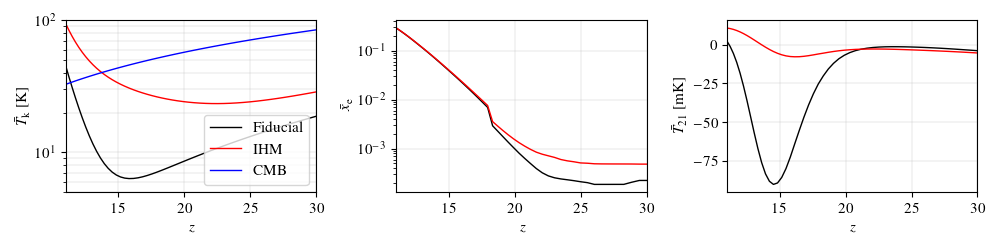

In [4]:
def Plot_Global_Full():
    LineWidth = 1
    FontSize = 11
    PlotFile = '/Users/cangtao/Desktop/Global_Quantities.pdf'

    f0 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/Fiducial.h5'
    f1 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/HMG.h5'

    lc = p21c.LightCone.read(f0)
    z0 = lc.node_redshifts
    t0 = lc.global_brightness_temp
    tk0 = lc.global_Tk
    xH0 = lc.global_xHI

    lc = p21c.LightCone.read(f1)
    z1 = lc.node_redshifts
    t1 = lc.global_brightness_temp
    tk1 = lc.global_Tk
    xH1 = lc.global_xHI
    # print(xH1)

    fig, axs = plt.subplots(1, 3, sharex = 1, sharey = 0)
    fig.set_size_inches(10, 2.5)
    
    idx = 0
    axs[idx].grid(True, which='both', linewidth = 0.2)
    axs[idx].plot(z0, tk0, 'k', linewidth = LineWidth, label='Fiducial')
    axs[idx].plot(z1, tk1, 'r', linewidth = LineWidth, label='IHM')
    axs[idx].plot(z1, 2.728*(1+z1), 'b', linewidth = LineWidth, label='CMB')
    axs[idx].legend(fontsize=FontSize, loc = 'lower right')
    axs[idx].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].set_ylabel('$\\bar{T}_{\mathrm{{k}}}$ [K]',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].tick_params(axis='both', which='both', labelsize = FontSize)
    axs[idx].set_xlim(11, 30)
    axs[idx].set_ylim(5, 1E2)
    axs[idx].set_yscale('log')

    idx = 1
    axs[idx].grid(True, which='major', linewidth = 0.2)
    #axs[idx].plot(z0, xH0, 'k', linewidth = LineWidth)
    #axs[idx].plot(z1, xH1, 'r', linewidth = LineWidth)
    axs[idx].semilogy(z0, 1-xH0, 'k', linewidth = LineWidth)
    axs[idx].semilogy(z1, 1-xH1, 'r', linewidth = LineWidth)
    
    # axs[idx].legend(fontsize=FontSize, loc = 'lower right')
    axs[idx].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].set_ylabel('$\\bar{x}_{\mathrm{{e}}}$',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].tick_params(axis='both', which='both', labelsize = FontSize)
    axs[idx].set_xlim(11, 30)
    # axs[idx].set_ylim(5, 1E2)
    # axs[idx].set_yscale('log')

    idx = 2
    axs[idx].grid(True, which='major', linewidth = 0.2) # Show grid, if u wanna show both minor and major grid, use which='both'
    axs[idx].plot(z0, t0, 'k', linewidth = LineWidth)
    axs[idx].plot(z1, t1, 'r', linewidth = LineWidth)
    # axs[idx].legend(fontsize=FontSize, loc = 'lower right')
    axs[idx].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].set_ylabel('$\\bar{T}_{21}$ [mK]',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].tick_params(axis='both', which='both', labelsize = FontSize)
    axs[idx].set_xlim(11, 30)
    # axs[idx].set_ylim(5, 1E2)
    # axs[idx].set_yscale('log')
    plt.tight_layout()
    plt.savefig(PlotFile)

Plot_Global_Full()


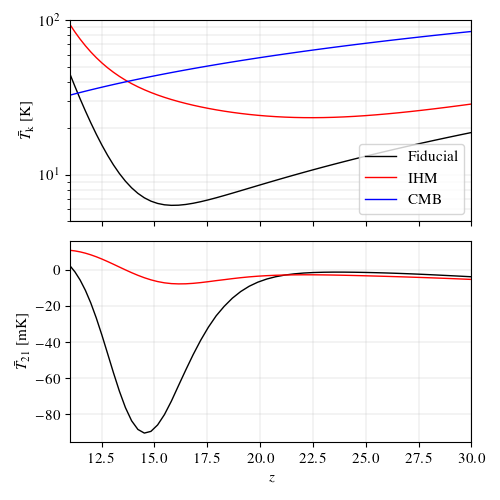

In [5]:
def Plot_Global():
    LineWidth = 1
    FontSize = 11
    PlotFile = '/Users/cangtao/Desktop/Global_Quantities.pdf'

    f0 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/Fiducial.h5'
    f1 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/HMG.h5'

    lc = p21c.LightCone.read(f0)
    z0 = lc.node_redshifts
    t0 = lc.global_brightness_temp
    tk0 = lc.global_Tk
    
    lc = p21c.LightCone.read(f1)
    z1 = lc.node_redshifts
    t1 = lc.global_brightness_temp
    tk1 = lc.global_Tk
    
    fig, axs = plt.subplots(2, 1, sharex = 1, sharey = 0)
    fig.set_size_inches(5, 5)
    
    idx = 0
    axs[idx].grid(True, which='both', linewidth = 0.2)
    axs[idx].plot(z0, tk0, 'k', linewidth = LineWidth, label='Fiducial')
    axs[idx].plot(z1, tk1, 'r', linewidth = LineWidth, label='IHM')
    axs[idx].plot(z1, 2.728*(1+z1), 'b', linewidth = LineWidth, label='CMB')
    axs[idx].legend(fontsize=FontSize, loc = 'lower right')
    axs[idx].set_ylabel('$\\bar{T}_{\mathrm{{k}}}$ [K]',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].tick_params(axis='both', which='both', labelsize = FontSize)# , direction = 'in')
    axs[idx].set_xlim(11, 30)
    axs[idx].set_ylim(5, 1E2)
    axs[idx].set_yscale('log')
    # axs[0].set_xticks([])

    idx = 1
    axs[idx].grid(True, which='major', linewidth = 0.2) # Show grid, if u wanna show both minor and major grid, use which='both'
    axs[idx].plot(z0, t0, 'k', linewidth = LineWidth)
    axs[idx].plot(z1, t1, 'r', linewidth = LineWidth)
    # axs[idx].legend(fontsize=FontSize, loc = 'lower right')
    axs[idx].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].set_ylabel('$\\bar{T}_{21}$ [mK]',fontsize=FontSize,fontname='Times New Roman')
    axs[idx].tick_params(axis='both', which='both', labelsize = FontSize)#, direction = 'in')
    # axs[idx].set_xlim(11, 30)
    # axs[idx].set_ylim(5, 1E2)
    # axs[idx].set_yscale('log')

    fig.subplots_adjust(hspace = 0.)
    # plt.subplots_adjust(wspace=0.0, hspace=0.0)# , left=0.06, right=0.995, bottom=0.1, top=0.95)
    
    plt.tight_layout()
    plt.savefig(PlotFile)

Plot_Global()


# Coeval Slice

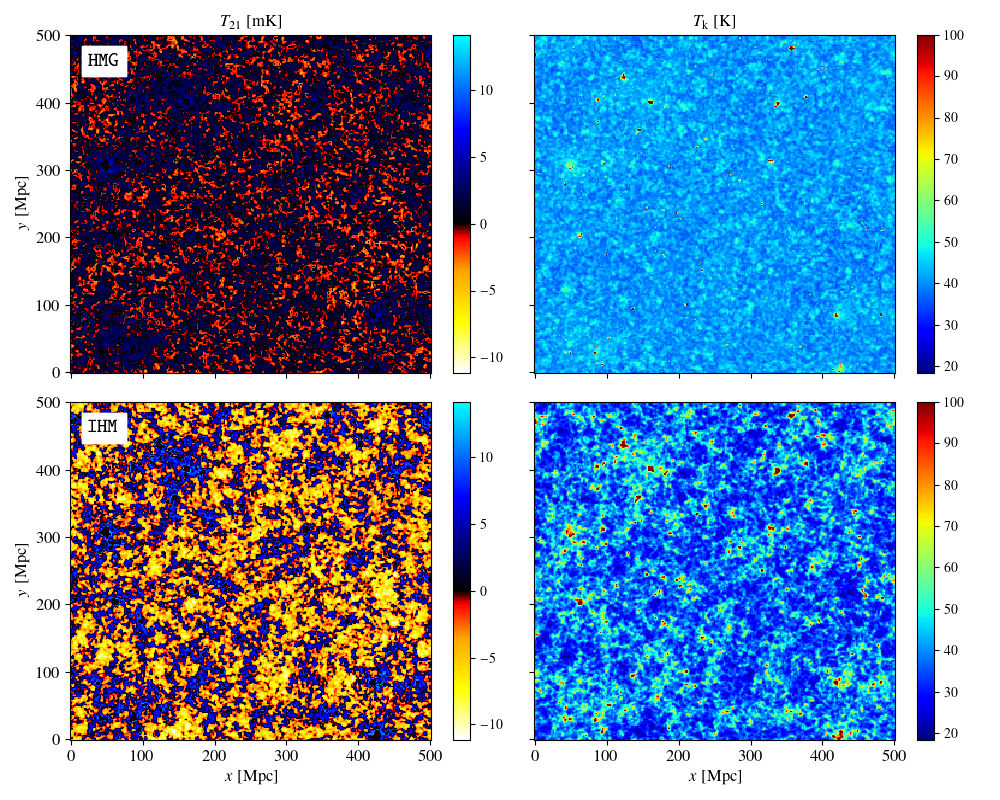

In [6]:
def Plot_Coeval_Slice():
    FontSize = 12
    redshift = 13.5
    PlotFile = '/Users/cangtao/Desktop/Coeval_Slice.pdf'

    f1 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/HMG.h5'
    f2 = '/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/IHM.h5'

    lc = p21c.LightCone.read(f1)
    redshifts = lc.lightcone_redshifts
    idx_best = np.argmin(np.abs(redshifts - redshift))
    t1 = lc.brightness_temp[:,:,idx_best]
    tk1 = lc.Tk_box[:,:,idx_best]
    
    lc = p21c.LightCone.read(f2)
    t2 = lc.brightness_temp[:,:,idx_best]
    tk2 = lc.Tk_box[:,:,idx_best]

    BOX_LEN = lc.user_params.BOX_LEN
    HII_DIM = lc.user_params.HII_DIM
    x = np.linspace(0, BOX_LEN, HII_DIM)
    y = x
    
    Tax = [[t1, tk1], [t2, tk2]]
    Texts = [['{\\tt HMG}, $T_{21}$ [mK]', '{\\tt HMG}, $T_{\mathrm{k}}$ [K]'],
             ['{\\tt IHM}, $T_{21}$ [mK]', '{\\tt IHM}, $T_{\mathrm{k}}$ [K]']]
    Texts = ['{\\tt HMG}', '{\\tt IHM}']
    
    fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_size_inches(10, 8)
    x, y = np.meshgrid(x, y)
    Tb = np.array([t1, t2])
    Tk = np.array([tk1, tk2])

    TbMin = np.min(Tb)
    TbMax = np.max(Tb)
    BlackLocation = -TbMin/(TbMax - TbMin)
    # print(BlackLocation)
    # print(np.mean(t1), np.mean(t2), '===')
    EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',\
             [(0, 'white'),(0.15, 'yellow'),(0.3, 'orange'),(0.4, 'red'),\
              (BlackLocation, 'black'),((BlackLocation + 1)/2, 'blue'),(1, 'cyan')])
    
    for SimIdx in [0, 1]:
        for StatIdx in [0, 1]:
            T = Tax[SimIdx][StatIdx]
            if StatIdx == 0:
                # c = axs[SimIdx, StatIdx].pcolor(x, y, T, cmap='jet', vmin = T.min(), vmax=T.max(), linewidth=0, rasterized=True)
                # c = axs[SimIdx, StatIdx].pcolor(x, y, T, cmap='jet', vmin = np.min(Tb), vmax = np.max(Tb), linewidth=0, rasterized=True)
                c = axs[SimIdx, StatIdx].pcolor(x, y, T, cmap = EoR_colour, vmin = np.min(Tb), vmax = np.max(Tb), linewidth=0, rasterized=True)
            else:
                c = axs[SimIdx, StatIdx].pcolor(x, y, T, cmap='jet', vmin = np.min(Tk), vmax = 100, linewidth=0, rasterized=True)
            cbar = fig.colorbar(c, ax=axs[SimIdx, StatIdx])
            axs[SimIdx, StatIdx].tick_params(axis='both', which='both', labelsize = FontSize)
            axs[SimIdx, 0].text(0.05, 0.95, Texts[SimIdx], rotation=0, verticalalignment='top', transform=axs[SimIdx, 0].transAxes,
                color = 'k', fontsize = FontSize*1.2, bbox={'facecolor': 'white', 'edgecolor': 'white', 'boxstyle': 'square'}, horizontalalignment='left')
    
    axs[0, 0].set_title('$T_{21}$ [mK]',fontsize=FontSize)
    axs[0, 1].set_title('$T_{\mathrm{k}}$ [K]',fontsize=FontSize)
    axs[0, 0].set_ylabel('$y$ [Mpc]',fontsize=FontSize,fontname='Times New Roman')
    axs[1, 0].set_ylabel('$y$ [Mpc]',fontsize=FontSize,fontname='Times New Roman')
    axs[1, 0].set_xlabel('$x$ [Mpc]',fontsize=FontSize,fontname='Times New Roman')
    axs[1, 1].set_xlabel('$x$ [Mpc]',fontsize=FontSize,fontname='Times New Roman')
    
    plt.tight_layout()

    plt.savefig(PlotFile)

Plot_Coeval_Slice()


# T21 PS

The Big one

Maximum PS difference = 134.47


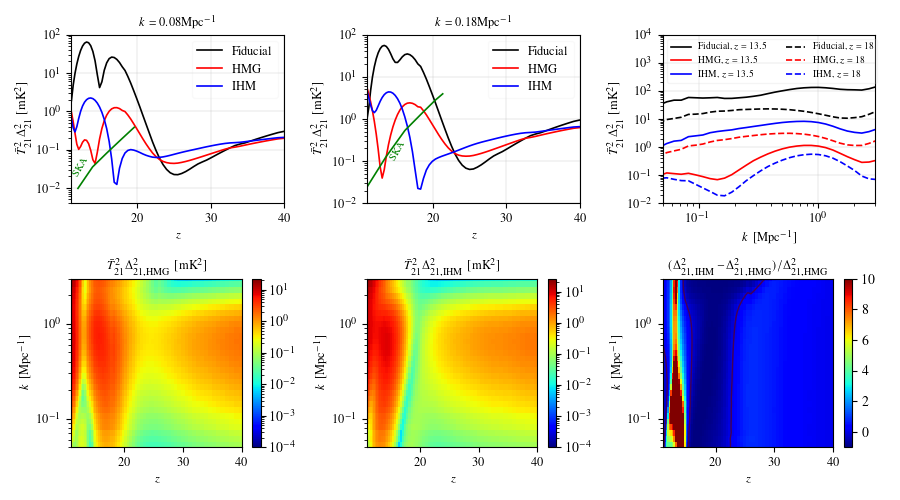

In [9]:
cutoff_SKA = 1
kmax = 3
zmax = 40
PlotFile = '/Users/cangtao/Desktop/PS_T21.pdf'
LineWidth = 1.2
FontSize = 9

PS_dataset = h5py.File('data/PowerSpectrums.h5', 'r')
PS_HMG = PS_dataset['HMG/Tb/ps'][:]
PS_IHM = PS_dataset['IHM/Tb/ps'][:]
PS_FID = PS_dataset['Fiducial/Tb/ps'][:]
PS_HMG[PS_HMG < 1E-200] = 1E-200
PS_IHM[PS_IHM < 1E-200] = 1E-200
PS_FID[PS_FID < 1E-200] = 1E-200
z_ax = PS_dataset['IHM/Tb/z'][:]
k_ax = PS_dataset['IHM/Tb/k'][:]
z_tmp = PS_dataset['HMG/Tb/z'][:]
k_tmp = PS_dataset['HMG/Tb/k'][:]
if np.sum(np.abs(z_ax-z_tmp)) > 1E-3 or np.sum(np.abs(k_ax-k_tmp)) > 1E-3:
    raise Exception('IHM and HMG has different z and k axis')
z_tmp = PS_dataset['Fiducial/Tb/z'][:]
k_tmp = PS_dataset['Fiducial/Tb/k'][:]
if np.sum(np.abs(z_ax-z_tmp)) > 1E-3 or np.sum(np.abs(k_ax-k_tmp)) > 1E-3:
    raise Exception('IHM and Fiducial has different z and k axis')
PS_dataset.close()

def Read_PS(fix_z, z, k, dataset):
    if fix_z:
        id1 = PL.Find_Index(x=z, x_axis=z_ax)
        id2 = id1+1
        z1 = z_ax[id1]
        z2 = z_ax[id2]
        f1 = dataset[id1, :]
        f2 = dataset[id2, :]
        f1, f2 = np.log10(f1), np.log10(f2)
        r = (f2 - f1)*(z-z1)/(z2 - z1) + f1
        r= 10**r
        return r
    else:
        id1 = PL.Find_Index(x=k, x_axis=k_ax)
        id2 = id1+1
        x = np.log10(k)
        x1 = np.log10(k_ax[id1])
        x2 = np.log10(k_ax[id2])
        f1 = dataset[:, id1]
        f2 = dataset[:, id2]
        f1, f2 = np.log10(f1), np.log10(f2)
        r = (f2 - f1)*(x-x1)/(x2 - x1) + f1
        r = 10**r
        return r
# PS(z)
PSz_fid_1 = Read_PS(fix_z=0, z=None, dataset=PS_FID, k = 0.08)
PSz_hmg_1 = Read_PS(fix_z=0, z=None, dataset=PS_HMG, k = 0.08)
PSz_main_1 = Read_PS(fix_z=0, z=None, dataset=PS_IHM, k = 0.08)
PSz_fid_2 = Read_PS(fix_z=0, z=None, dataset=PS_FID, k = 0.18)
PSz_hmg_2 = Read_PS(fix_z=0, z=None, dataset=PS_HMG, k = 0.18)
PSz_main_2 = Read_PS(fix_z=0, z=None, dataset=PS_IHM, k = 0.18)

# PS(k)
PSk_fid_1 = Read_PS(fix_z=1, k=None, dataset=PS_FID, z=13.5)
PSk_hmg_1 = Read_PS(fix_z=1, k=None, dataset=PS_HMG, z=13.5)
PSk_main_1 = Read_PS(fix_z=1, k=None, dataset=PS_IHM, z=13.5)

PSk_fid_2 = Read_PS(fix_z=1, k=None, dataset=PS_FID, z=18)
PSk_hmg_2 = Read_PS(fix_z=1, k=None, dataset=PS_HMG, z=18)
PSk_main_2 = Read_PS(fix_z=1, k=None, dataset=PS_IHM, z=18)

# SKA Sensitivities
CurvePath = '/Users/cangtao/FileVault/Soft/PyLab/Curve_Data/'
SKA_1 = np.load(CurvePath+'/2110.06173.SKA_1000h_k_0.1.npz')
SKA_1_z, SKA_1_ps = SKA_1['x'], SKA_1['y']
SKA_2 = np.load(CurvePath+'2110.06173.SKA_1000h_k_0.4.npz')
SKA_2_z, SKA_2_ps = SKA_2['x'], SKA_2['y']
SKA_1 = np.load(CurvePath+'1310.0029.SKA_0.08.npz')
SKA_1_z, SKA_1_ps = SKA_1['x'], SKA_1['y']
SKA_2 = np.load(CurvePath+'1310.0029.SKA_0.18.npz')
SKA_2_z, SKA_2_ps = SKA_2['x'], SKA_2['y']

plt.rcParams.update({'font.family':'Times'})
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(2, 3, sharex = False, sharey = False)
fig.set_size_inches(9, 5)

# PS(z) @ k=0.08
axs[0, 0].grid(True, which='major', linewidth = 0.2)
axs[0, 0].plot(z_ax, PSz_fid_1, 'k', linewidth = LineWidth, label='Fiducial')
axs[0, 0].plot(z_ax, PSz_hmg_1, 'r', linewidth = LineWidth, label='HMG')
axs[0, 0].plot(z_ax, PSz_main_1, 'b', linewidth = LineWidth, label='IHM')
if cutoff_SKA:
    SKA_1_ps[SKA_1_z > 19.6] = np.nan
axs[0, 0].plot(SKA_1_z, SKA_1_ps, 'g', linewidth = LineWidth)
axs[0, 0].text(11, 2e-2, 'SKA', size=FontSize/1.2, rotation = 60, color='g')
axs[0, 0].set_title('$k = 0.08 {\mathrm{Mpc^{-1}}}$',fontsize=FontSize)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 0].set_ylabel('$\\bar{T}^2_{21}\Delta^2_{21}\ [{\mathrm{mK^2}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 0].tick_params(axis='both', which='both', labelsize = FontSize)
axs[0, 0].set_xticks(np.linspace(10, 60, 6))
axs[0, 0].set_xlim(11, zmax)
axs[0, 0].set_ylim(4E-3, 100)
LGD_00 = axs[0, 0].legend(fontsize=FontSize, loc = 'upper right')
LGD_00.get_frame().set_alpha(0.1)

# PS(z) @ k=0.18
axs[0, 1].grid(True, which='major', linewidth = 0.2)
axs[0, 1].plot(z_ax, PSz_fid_2, 'k', linewidth = LineWidth, label='Fiducial')
axs[0, 1].plot(z_ax, PSz_hmg_2, 'r', linewidth = LineWidth, label='HMG')
axs[0, 1].plot(z_ax, PSz_main_2, 'b', linewidth = LineWidth, label='IHM')
axs[0, 1].plot(SKA_2_z, SKA_2_ps, 'g', linewidth = LineWidth)
axs[0, 1].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 1].set_ylabel('$\\bar{T}^2_{21}\Delta^2_{21}\ [{\mathrm{mK^2}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 1].tick_params(axis='both', which='both', labelsize = FontSize)
axs[0, 1].set_yscale('log')
axs[0, 1].set_xticks(np.linspace(10, 60, 6))
axs[0, 1].set_xlim(11, zmax)
axs[0, 1].set_ylim(1E-2, 100)
axs[0, 1].set_title('$k = 0.18 {\mathrm{Mpc^{-1}}}$',fontsize=FontSize)
axs[0, 1].text(14, 1e-1, "SKA", size=FontSize/1.2, rotation = 60, color='g')
LGD = axs[0, 1].legend(fontsize=FontSize, loc = 'upper right')
LGD.get_frame().set_alpha(0.1)

# PS(k)
axs[0, 2].grid(True, which='major', linewidth = 0.2)
axs[0, 2].plot(k_ax, PSk_fid_1, 'k', linewidth = LineWidth, label='Fiducial, $z = 13.5$')
axs[0, 2].plot(k_ax, PSk_hmg_1, 'r', linewidth = LineWidth, label='HMG, $z = 13.5$')
axs[0, 2].plot(k_ax, PSk_main_1, 'b', linewidth = LineWidth, label='IHM, $z = 13.5$')

axs[0, 2].plot(k_ax, PSk_fid_2, '--k', linewidth = LineWidth, label='Fiducial, $z = 18$')
axs[0, 2].plot(k_ax, PSk_hmg_2, '--r', linewidth = LineWidth, label='HMG, $z = 18$')
axs[0, 2].plot(k_ax, PSk_main_2, '--b', linewidth = LineWidth, label='IHM, $z = 18$')

axs[0, 2].set_ylabel('$k\ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 2].set_xlabel('$k\ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 2].set_ylabel('$\\bar{T}^2_{21}\Delta^2_{21}\ [{\mathrm{mK^2}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[0, 2].tick_params(axis='both', which='both', labelsize = FontSize)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].set_xlim(0.05, kmax)
axs[0, 2].set_ylim(1e-2, 1E4)
# axs[0, 2].set_title('$z=13$',fontsize=FontSize)
LGD_02 = axs[0, 2].legend(loc='upper left', bbox_to_anchor=(0., 1.), ncol=2, fontsize=FontSize/1.3)
LGD_02.get_frame().set_alpha(0.2)

# PS2D, HMG
zax, kax = np.meshgrid(z_ax, k_ax)
c10 = axs[1, 0].pcolor(zax, kax, PS_HMG.T, cmap='jet', norm = LogNorm(vmin = 1e-4, vmax = PS_HMG.max()), rasterized=True)
axs[1, 0].set_yticks([])
cbar = fig.colorbar(c10, ax=axs[1, 0])
axs[1, 0].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 0].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 0].set_ylabel('$k\ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 0].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 0].set_xticks(np.linspace(10, 60, 6))
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlim(11, zmax)
axs[1, 0].set_ylim(0.05, kmax)
axs[1, 0].set_title('$\\bar{T}^2_{21}\Delta^2_{21,{\mathrm{HMG}}}\ [{\mathrm{mK^2}}]$',fontsize=FontSize)

# PS2D, IHM
c11 = axs[1, 1].pcolor(zax, kax, PS_IHM.T, cmap='jet', norm = LogNorm(vmin = 1e-4, vmax = PS_IHM.max()), rasterized=True)
axs[1, 1].set_yticks([])
cbar = fig.colorbar(c11, ax=axs[1, 1])
axs[1, 1].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 1].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 1].set_ylabel('$k\ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 1].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 1].set_xticks(np.linspace(10, 60, 6))
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlim(11, zmax)
axs[1, 1].set_ylim(0.05, kmax)
axs[1, 1].set_title('$\\bar{T}^2_{21}\Delta^2_{21,{\mathrm{IHM}}}\ [{\mathrm{mK^2}}]$',fontsize=FontSize)

# Dif2D
ps_dif = PS_IHM/PS_HMG - 1
c12 = axs[1, 2].pcolor(zax, kax, ps_dif.T, cmap='jet', vmax = 10, rasterized=True)
axs[1, 2].contour(zax, kax, ps_dif.T, levels=[0], color = 'black', linewidths=1)
axs[1, 2].set_yticks([])
cbar = fig.colorbar(c12, ax=axs[1, 2])
axs[1, 2].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 2].set_xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 2].set_ylabel('$k\ [{\mathrm{Mpc^{-1}}}]$',fontsize=FontSize,fontname='Times New Roman')
axs[1, 2].tick_params(axis='both', which='both', labelsize = FontSize)
axs[1, 2].set_xticks(np.linspace(10, 50, 5))
axs[1, 2].set_yscale('log')
axs[1, 2].set_xlim(11, zmax)
axs[1, 2].set_ylim(0.05, kmax)
axs[1, 2].set_title('$(\Delta^2_{21, {\mathrm{IHM}}} - \Delta^2_{21, {\mathrm{HMG}}}) / \Delta^2_{21, {\mathrm{HMG}}}$',fontsize=FontSize)

plt.xticks(size=FontSize)
plt.yticks(size=FontSize)
plt.tight_layout()
plt.savefig(PlotFile)
print("Maximum PS difference = {:.2f}".format(np.max(ps_dif)))
# plt.show()
